# FINAL PROJECT: MNIST handwritten digit images to train a MLP  
### Group 5: Shambhavi Danayak, Kimaya D Sawant, Pradnya R Ghadge, 

#  1. Import Libraries

We first import all necessary libraries including PyTorch, torchvision for datasets and transforms, and matplotlib/numpy for visualization.

In [65]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import random
import math
import pandas as pd
import os

## TASK 2: 
a helper function that can read all image files (following filename convention defined in Task1) into a Numpy array, and assign the corresponding labels in another Numpy array.  
- load ".png" handwritten data
- extract label
- verify shape
- return images and labels

In [7]:
import os
os.getcwd()


'/Users/shambhavidanayak/Desktop/CSUChico/Spring2025/CSCI580/updated/CSCI580_Spring25_Group5/FinalProject/notebooks'

In [8]:
os.chdir("..")  
print("Updated CWD:", os.getcwd())

Updated CWD: /Users/shambhavidanayak/Desktop/CSUChico/Spring2025/CSCI580/updated/CSCI580_Spring25_Group5/FinalProject


In [10]:
os.chdir("../FinalProject/")
print("Updated CWD:", os.getcwd())

Updated CWD: /Users/shambhavidanayak/Desktop/CSUChico/Spring2025/CSCI580/updated/CSCI580_Spring25_Group5/FinalProject


In [11]:
import os
from PIL import Image

In [12]:
def ProjectDataLoader(folder_path="HandwrittenData/digits"):
    image_list = [] #stores image pixels
    label_list = [] #corresponding digit labels

    for filename in os.listdir(folder_path):
        if filename.endswith(".png") and filename[0].isdigit():
            try:
                label = int(filename.split("-")[0])

                img_path = os.path.join(folder_path, filename)
                image = Image.open(img_path).convert("L")  # "L" = 8-bit pixels, black and white
                # Resize 
                image_array = np.array(image)

                if image_array.shape != (28, 28):
                    raise ValueError(f"Image {filename} is not 28x28 pixels")

                image_list.append(image_array)
                label_list.append(label)

            except Exception as e:
                print(f"Skipping {filename}: {e}")

    images = np.array(image_list, dtype=np.uint8)
    labels = np.array(label_list, dtype=np.int64)

    print(f"Loaded {len(images)} images and labels.")
    return images, labels


In [13]:
images, labels = ProjectDataLoader()
print("Shape of image set:", images.shape)
print("Sample label:", labels[0])

Loaded 330 images and labels.
Shape of image set: (330, 28, 28)
Sample label: 9


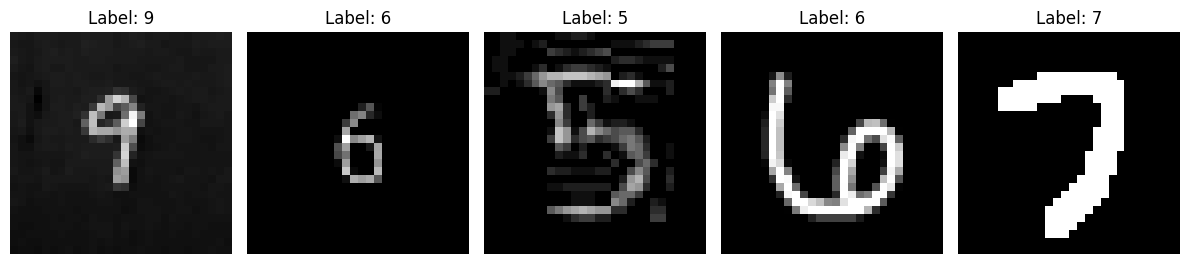

In [14]:
num_images = 5

fig, axes = plt.subplots(1, num_images, figsize=(12, 3))  

for i in range(num_images):
    axes[i].imshow(images[i], cmap='gray')
    axes[i].set_title(f"Label: {labels[i]}")
    axes[i].axis('off')  

plt.tight_layout()
plt.show()

## Task 3: Preprocess image data using Pytorch

In [15]:
def preprocess_images(images_np):
    preprocess = transforms.Compose([
        transforms.ToTensor(),                         
        transforms.Normalize((0.5,), (0.5,))           
    ])

    processed_images = []
    for i in range(images_np.shape[0]):
        img_tensor = preprocess(images_np[i])          
        processed_images.append(img_tensor)

    # Stack into a single tensor: shape → (N, 1, 28, 28)
    return torch.stack(processed_images)

In [16]:
images_tensor = preprocess_images(images)     
labels_tensor = torch.from_numpy(labels) 

In [17]:
print("Processed image tensor shape:", images_tensor.shape)
print("Pixel range:", images_tensor.min().item(), "to", images_tensor.max().item())

Processed image tensor shape: torch.Size([330, 1, 28, 28])
Pixel range: -1.0 to 1.0


In [18]:
os.makedirs("SavedData", exist_ok=True)
torch.save(images_tensor, "SavedData/images_tensor.pt")
torch.save(labels_tensor, "SavedData/labels_tensor.pt")

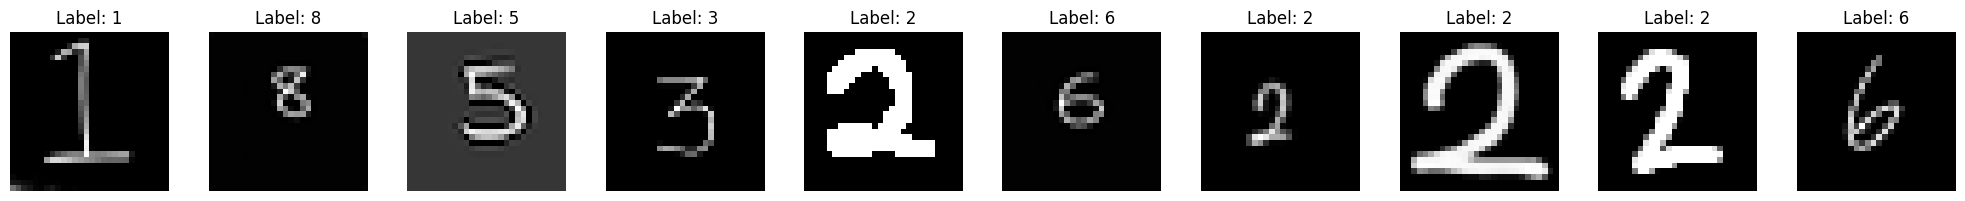

In [19]:
images_tensor = torch.load("SavedData/images_tensor.pt")
labels_tensor = torch.load("SavedData/labels_tensor.pt")
def show_random_images(images_tensor, labels_tensor, n=10):
    indices = random.sample(range(len(images_tensor)), n)
    plt.figure(figsize=(n * 2, 2))
    for i, idx in enumerate(indices):
        image = images_tensor[idx].squeeze().numpy()
        label = labels_tensor[idx].item()

        plt.subplot(1, n, i + 1)
        plt.imshow(image, cmap="gray")
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Usage:
show_random_images(images_tensor, labels_tensor, n=10)

# Train MLP on MNIST

### load MNIST dataset

In [20]:
# doing this again as MNIST DATASET is not in the form of NumPy array
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [21]:
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform) #~60000 train images
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform) #~10000 test images

train_dataset, val_dataset = random_split(train_dataset, [50000, 10000])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [22]:
## visualize  loaded data (Train= Learn, Val= Tune, Test= Prove)

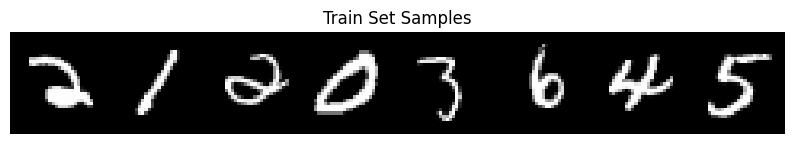

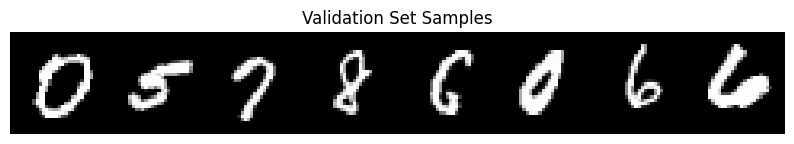

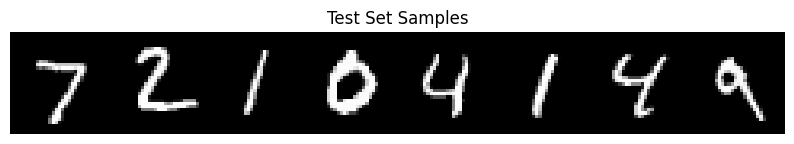

In [23]:
def show_batch(loader, title="Sample Images from DataLoader"):
    images, labels = next(iter(loader))  
    img_grid = torchvision.utils.make_grid(images[:8], nrow=8, padding=2, normalize=True)

    plt.figure(figsize=(10, 2))
    plt.imshow(img_grid.permute(1, 2, 0))  
    plt.title(title)
    plt.axis("off")
    plt.show()

show_batch(train_loader, title="Train Set Samples")
show_batch(val_loader, title="Validation Set Samples")
show_batch(test_loader, title="Test Set Samples")

In [24]:
## MLP Architecture (2 hidden, 1 input , 1 output layer), with ReLU, loss function CrossEntropyLoss, lr=0.001 and 10 rpochs

In [25]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),                  
            nn.Linear(784, 256), #hidden layer 1
            nn.ReLU(),
            nn.Linear(256, 128), #hidden layer 2
            nn.ReLU(),
            nn.Linear(128, 10) #output layer 10 neurons since we have classes           
        )

    def forward(self, x):
        return self.model(x)

model = MLP()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    # Validation loop
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {running_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}% "
          f"| Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {val_acc:.2f}%")

#save model
os.makedirs("SavedModels", exist_ok=True)
torch.save(model.state_dict(), "SavedModels/mlp_mnist_state_dict.pth")
torch.save(model, "SavedModels/mlp_mnist_full_model.pth")
print("Model saved successfully!")

Epoch [1/10] Train Loss: 0.3752 | Train Acc: 88.61% | Val Loss: 0.2208 | Val Acc: 93.10%
Epoch [2/10] Train Loss: 0.1686 | Train Acc: 94.77% | Val Loss: 0.1511 | Val Acc: 95.06%
Epoch [3/10] Train Loss: 0.1244 | Train Acc: 96.15% | Val Loss: 0.1205 | Val Acc: 96.24%
Epoch [4/10] Train Loss: 0.0991 | Train Acc: 96.89% | Val Loss: 0.1039 | Val Acc: 96.77%
Epoch [5/10] Train Loss: 0.0839 | Train Acc: 97.32% | Val Loss: 0.1061 | Val Acc: 96.76%
Epoch [6/10] Train Loss: 0.0707 | Train Acc: 97.75% | Val Loss: 0.1028 | Val Acc: 96.92%
Epoch [7/10] Train Loss: 0.0645 | Train Acc: 97.94% | Val Loss: 0.0958 | Val Acc: 97.13%
Epoch [8/10] Train Loss: 0.0583 | Train Acc: 98.06% | Val Loss: 0.0956 | Val Acc: 97.35%
Epoch [9/10] Train Loss: 0.0496 | Train Acc: 98.40% | Val Loss: 0.0940 | Val Acc: 97.33%
Epoch [10/10] Train Loss: 0.0431 | Train Acc: 98.57% | Val Loss: 0.1250 | Val Acc: 96.75%
Model saved successfully!


In [26]:
## test accuracy (prove) on MNIST DATA
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Test Accuracy on MNIST: {100 * correct / total:.2f}%")

Final Test Accuracy on MNIST: 96.44%


# Test Trained MLP on Handwritten Dataset 

In [27]:
# Load your handwritten test data
images_tensor = torch.load("SavedData/images_tensor.pt")
labels_tensor = torch.load("SavedData/labels_tensor.pt")

# Make sure to move tensors to same device as model
images_tensor = images_tensor.to(device)
labels_tensor = labels_tensor.to(device)


In [28]:
model.eval()
correct = 0
total = labels_tensor.size(0)

with torch.no_grad():
    outputs = model(images_tensor)
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels_tensor).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on Handwritten Digits: {accuracy:.2f}%")

Accuracy on Handwritten Digits: 30.91%


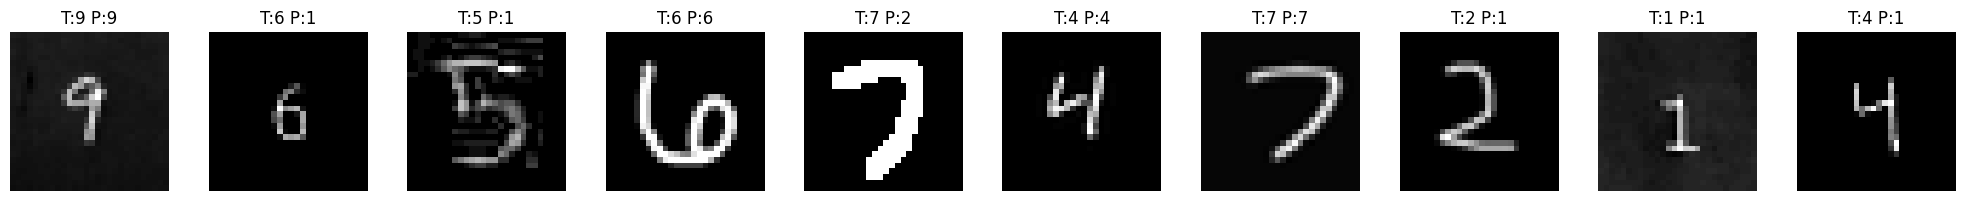

In [29]:
## plot the resulting handwritten data on the saved mode;l
import matplotlib.pyplot as plt

def show_predictions(images, labels, preds, n=10):
    plt.figure(figsize=(n*2, 2))
    for i in range(n):
        img = images[i].cpu().squeeze().numpy()
        true = labels[i].item()
        pred = preds[i].item()
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap="gray")
        plt.title(f"T:{true} P:{pred}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Show predictions
show_predictions(images_tensor, labels_tensor, predicted, n=10)

### Augmenting Handwritten Dataset

In [30]:
images_tensor = torch.load("SavedData/images_tensor.pt")
labels_tensor = torch.load("SavedData/labels_tensor.pt")

Reference links: 
- https://pytorch.org/vision/main/generated/torchvision.transforms.RandomAffine.html

In [31]:
handwritten_transform = transforms.RandomAffine(
    degrees=15,             #  rotation
    translate=(0.1, 0.1),   #  shift
    scale=(0.9, 1.1)        # zoom in/out
)

class AugmentedHandwrittenDataset(Dataset):
    def __init__(self, images_tensor, labels_tensor, transform=None):
        self.images = images_tensor  
        self.labels = labels_tensor
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

augmented_dataset = AugmentedHandwrittenDataset(
    images_tensor, labels_tensor, transform=handwritten_transform)
augmented_loader = DataLoader(augmented_dataset, batch_size=64, shuffle=False)

In [32]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in augmented_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on AUGMENTED Handwritten Digits: {accuracy:.2f}%")

Accuracy on AUGMENTED Handwritten Digits: 21.21%


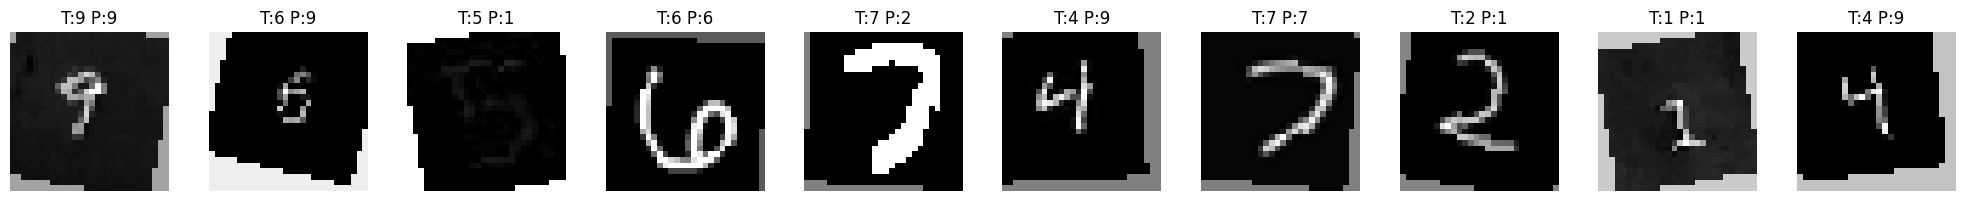

In [33]:
images, labels = next(iter(augmented_loader))
outputs = model(images.to(device))
_, preds = outputs.max(1)

show_predictions(images, labels, preds.cpu(), n=10)

### Augmenting MNIST Dataset to train again

In [34]:
augmented_mnist_transform = transforms.Compose([
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

augmented_mnist_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=augmented_mnist_transform)
train_dataset, val_dataset = random_split(augmented_mnist_dataset, [50000, 10000])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [35]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)

model = MLP()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [36]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

#save model
os.makedirs("SavedModels", exist_ok=True)
torch.save(model.state_dict(), "SavedModels/mlp_mnist_augmented_state_dict.pth")
torch.save(model, "SavedModels/mlp_mnist_augmented_full_model.pth")
print("Model saved successfully!")

Epoch 1/10, Train Acc: 72.07%, Val Acc: 84.46%
Epoch 2/10, Train Acc: 88.02%, Val Acc: 90.48%
Epoch 3/10, Train Acc: 90.64%, Val Acc: 90.88%
Epoch 4/10, Train Acc: 91.95%, Val Acc: 92.82%
Epoch 5/10, Train Acc: 92.56%, Val Acc: 91.89%
Epoch 6/10, Train Acc: 93.18%, Val Acc: 93.49%
Epoch 7/10, Train Acc: 93.78%, Val Acc: 93.34%
Epoch 8/10, Train Acc: 93.91%, Val Acc: 94.32%
Epoch 9/10, Train Acc: 94.10%, Val Acc: 94.23%
Epoch 10/10, Train Acc: 94.55%, Val Acc: 93.93%
Model saved successfully!


In [37]:
import os
os.listdir("SavedModels")

['mlp_mnist_augmented_state_dict.pth',
 'mlp_mnist_full_model.pth',
 'mlp_mnist_augmented_withGridSearchResults_full_model.pth',
 'mlp_mnist_full_model-Copy1.pth',
 'mlp_mnist_augmented_full_model.pth',
 'mlp_mnist_state_dict.pth',
 'mlp_mnist_augmented_withGridSearchResults_state_dict.pth',
 'mlp_mnist_state_dict-Copy1.pth']

In [38]:
## eval on handwritten

In [39]:
images_tensor = torch.load("SavedData/images_tensor.pt")
labels_tensor = torch.load("SavedData/labels_tensor.pt")

test_loader = DataLoader(TensorDataset(images_tensor, labels_tensor), batch_size=64, shuffle=False)

# Evaluate
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on Handwritten Digits (after training on Augmented MNIST): {accuracy:.2f}%")

Accuracy on Handwritten Digits (after training on Augmented MNIST): 46.97%


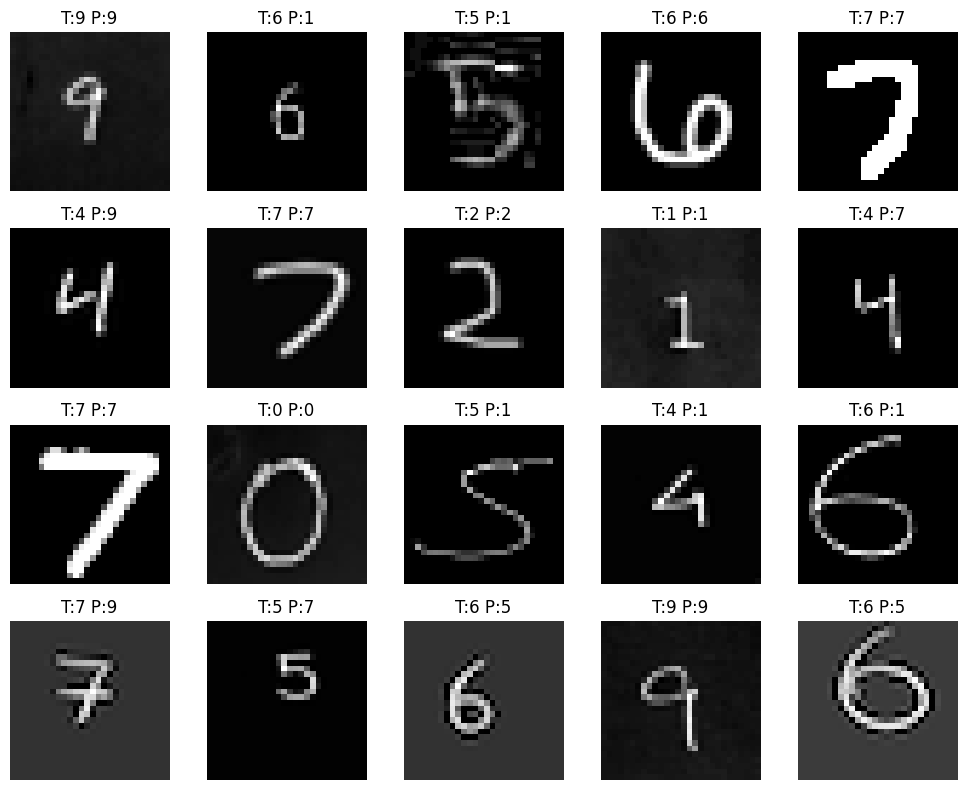

In [40]:
def show_predictions(images, labels, preds, n=20, per_row=5):
    rows = math.ceil(n / per_row)
    plt.figure(figsize=(per_row * 2, rows * 2))

    for i in range(n):
        img = images[i].cpu().squeeze().numpy()
        true = labels[i].item()
        pred = preds[i].item()

        plt.subplot(rows, per_row, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"T:{true} P:{pred}")
        plt.axis("off")

    plt.tight_layout()
    plt.show() 

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, preds = outputs.max(1)

show_predictions(images, labels, preds, n=20, per_row=5)

### Trying Grid Search for Hyperparameter Tuning

In [41]:
# defining grid
hidden_layers_list = [(256, 128), (512, 256)]
learning_rates = [0.01, 0.001]
optimizers = ['adam', 'sgd', 'rmsprop']
activations = ['relu', 'leaky_relu', 'tanh']

#model creation function
def create_model(hidden_sizes, activation_name):
    # Select activation
    if activation_name == 'relu':
        act = nn.ReLU()
    elif activation_name == 'leaky_relu':
        act = nn.LeakyReLU()
    elif activation_name == 'tanh':
        act = nn.Tanh()
    else:
        raise ValueError("Unsupported activation")

    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, hidden_sizes[0]),
        act,
        nn.Linear(hidden_sizes[0], hidden_sizes[1]),
        act,
        nn.Linear(hidden_sizes[1], 10)
    )

In [42]:
# training loop for all grid search 

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
results = []

for hidden in hidden_layers_list:
    for lr in learning_rates:
        for opt_name in optimizers:
            for act_name in activations:
                print(f"\n Trying → Hidden: {hidden}, LR: {lr}, Optimizer: {opt_name}, Activation: {act_name}")
                
                model = create_model(hidden, act_name).to(device)

                # Optimizer selection
                if opt_name == 'adam':
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                elif opt_name == 'sgd':
                    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
                elif opt_name == 'rmsprop':
                    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
                else:
                    raise ValueError("Unknown optimizer")

                # Train for a few epochs (e.g., 3–5 for quick search)
                for epoch in range(3):
                    model.train()
                    for images, labels in train_loader:
                        images, labels = images.to(device), labels.to(device)
                        optimizer.zero_grad()
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()

                # Evaluate on validation set
                model.eval()
                correct, total = 0, 0
                with torch.no_grad():
                    for images, labels in val_loader:
                        images, labels = images.to(device), labels.to(device)
                        outputs = model(images)
                        _, predicted = outputs.max(1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()
                val_acc = 100 * correct / total
                print(f" Val Acc: {val_acc:.2f}%")

                results.append((hidden, lr, opt_name, act_name, val_acc))



 Trying → Hidden: (256, 128), LR: 0.01, Optimizer: adam, Activation: relu
 Val Acc: 81.06%

 Trying → Hidden: (256, 128), LR: 0.01, Optimizer: adam, Activation: leaky_relu
 Val Acc: 82.49%

 Trying → Hidden: (256, 128), LR: 0.01, Optimizer: adam, Activation: tanh
 Val Acc: 10.18%

 Trying → Hidden: (256, 128), LR: 0.01, Optimizer: sgd, Activation: relu
 Val Acc: 91.38%

 Trying → Hidden: (256, 128), LR: 0.01, Optimizer: sgd, Activation: leaky_relu
 Val Acc: 90.64%

 Trying → Hidden: (256, 128), LR: 0.01, Optimizer: sgd, Activation: tanh
 Val Acc: 91.40%

 Trying → Hidden: (256, 128), LR: 0.01, Optimizer: rmsprop, Activation: relu
 Val Acc: 69.84%

 Trying → Hidden: (256, 128), LR: 0.01, Optimizer: rmsprop, Activation: leaky_relu
 Val Acc: 55.43%

 Trying → Hidden: (256, 128), LR: 0.01, Optimizer: rmsprop, Activation: tanh
 Val Acc: 9.89%

 Trying → Hidden: (256, 128), LR: 0.001, Optimizer: adam, Activation: relu
 Val Acc: 89.95%

 Trying → Hidden: (256, 128), LR: 0.001, Optimizer: ada

In [44]:
# best config
best = max(results, key=lambda x: x[4])
print(f"\n Best Config → Hidden: {best[0]}, LR: {best[1]}, Optimizer: {best[2]}, Activation: {best[3]}, Val Acc: {best[4]:.2f}%")


 Best Config → Hidden: (512, 256), LR: 0.01, Optimizer: sgd, Activation: leaky_relu, Val Acc: 92.70%


In [45]:
import os
print(os.getcwd())


/Users/shambhavidanayak/Desktop/CSUChico/Spring2025/CSCI580/updated/CSCI580_Spring25_Group5/FinalProject


In [46]:
df = pd.DataFrame(results, columns=["Hidden Layers", "Learning Rate", "Optimizer", "Activation", "Val Accuracy (%)"])
df_sorted = df.sort_values(by="Val Accuracy (%)", ascending=False)
print(df_sorted) 
os.makedirs("results", exist_ok=True)
df_sorted.to_csv("results/grid_search_results.csv", index=False)

   Hidden Layers  Learning Rate Optimizer  Activation  Val Accuracy (%)
22    (512, 256)          0.010       sgd  leaky_relu             92.70
21    (512, 256)          0.010       sgd        relu             92.41
27    (512, 256)          0.001      adam        relu             92.30
28    (512, 256)          0.001      adam  leaky_relu             92.20
5     (256, 128)          0.010       sgd        tanh             91.40
3     (256, 128)          0.010       sgd        relu             91.38
29    (512, 256)          0.001      adam        tanh             90.83
4     (256, 128)          0.010       sgd  leaky_relu             90.64
23    (512, 256)          0.010       sgd        tanh             90.47
10    (256, 128)          0.001      adam  leaky_relu             90.23
9     (256, 128)          0.001      adam        relu             89.95
11    (256, 128)          0.001      adam        tanh             89.89
16    (256, 128)          0.001   rmsprop  leaky_relu           

In [47]:
#defining model again in accordance with the grid search result

In [48]:
class BestMLP(nn.Module):
    def __init__(self):
        super(BestMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.model(x) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BestMLP().to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [49]:
num_epochs = 15 

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

#save model
os.makedirs("SavedModels", exist_ok=True)
torch.save(model.state_dict(), "SavedModels/mlp_mnist_augmented_withGridSearchResults_state_dict.pth")
torch.save(model, "SavedModels/mlp_mnist_augmented_withGridSearchResults_full_model.pth")
print("Model saved successfully!")

Epoch [1/15], Train Acc: 74.49%, Val Acc: 78.93%
Epoch [2/15], Train Acc: 88.88%, Val Acc: 88.69%
Epoch [3/15], Train Acc: 91.38%, Val Acc: 92.11%
Epoch [4/15], Train Acc: 92.66%, Val Acc: 83.08%
Epoch [5/15], Train Acc: 93.33%, Val Acc: 89.71%
Epoch [6/15], Train Acc: 93.68%, Val Acc: 93.16%
Epoch [7/15], Train Acc: 94.30%, Val Acc: 75.65%
Epoch [8/15], Train Acc: 94.52%, Val Acc: 94.76%
Epoch [9/15], Train Acc: 94.92%, Val Acc: 95.06%
Epoch [10/15], Train Acc: 95.13%, Val Acc: 95.76%
Epoch [11/15], Train Acc: 95.21%, Val Acc: 93.69%
Epoch [12/15], Train Acc: 95.39%, Val Acc: 95.30%
Epoch [13/15], Train Acc: 95.46%, Val Acc: 96.02%
Epoch [14/15], Train Acc: 95.60%, Val Acc: 91.88%
Epoch [15/15], Train Acc: 95.67%, Val Acc: 95.73%
Model saved successfully!


In [59]:
images_tensor = torch.load("SavedData/images_tensor.pt")
labels_tensor = torch.load("SavedData/labels_tensor.pt")
from torch.utils.data import TensorDataset, DataLoader

test_loader = DataLoader(TensorDataset(images_tensor, labels_tensor), batch_size=64, shuffle=False)

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f" Accuracy on Handwritten Digits (Best MLP Config): {accuracy:.2f}%")


 Accuracy on Handwritten Digits (Best MLP Config): 50.61%


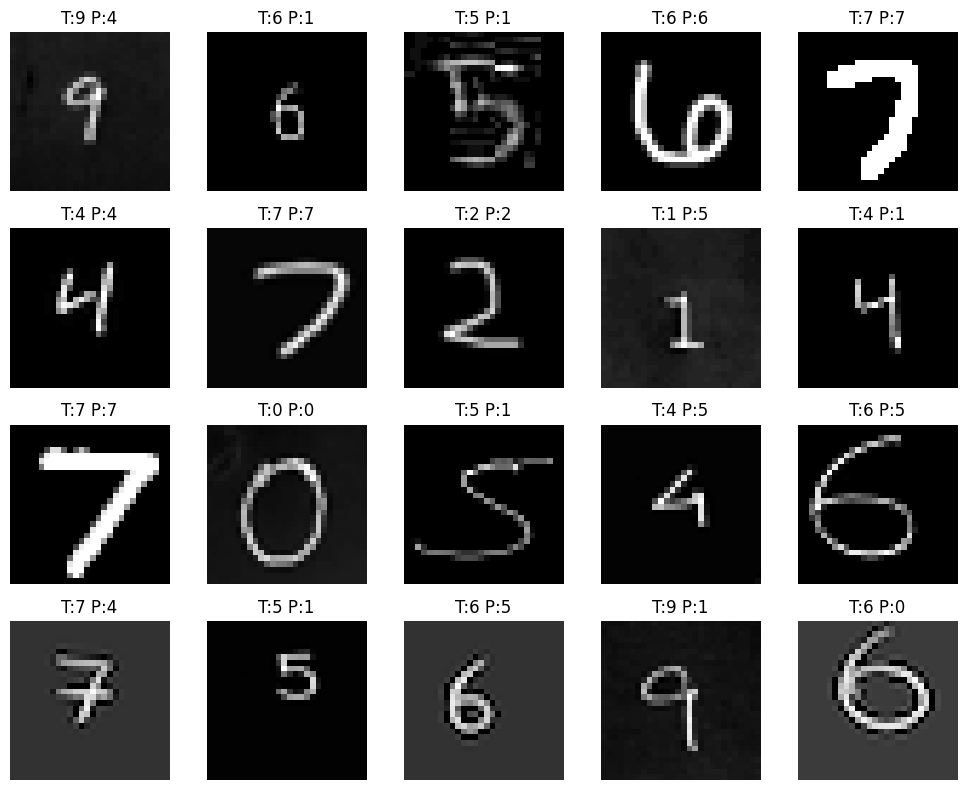

In [60]:
def show_predictions(images, labels, preds, n=20, per_row=5):
    rows = math.ceil(n / per_row)
    plt.figure(figsize=(per_row * 2, rows * 2))

    for i in range(n):
        img = images[i].cpu().squeeze().numpy()
        true = labels[i].item()
        pred = preds[i].item()

        plt.subplot(rows, per_row, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"T:{true} P:{pred}")
        plt.axis("off")

    plt.tight_layout()
    plt.show() 

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, preds = outputs.max(1)

show_predictions(images, labels, preds, n=20, per_row=5)

In [63]:
all_preds = []
all_labels = []

# Collect predictions and labels
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

# Confirm both are non-empty
print(f"Predicted labels: {len(all_preds)}")
print(f"True labels: {len(all_labels)}")

# Only then generate report
if all_preds and all_labels:
    from sklearn.metrics import classification_report
    print(classification_report(all_labels, all_preds, digits=4))
else:
    print("Prediction or label list is empty. Check test_loader or model inference.")


Predicted labels: 330
True labels: 330
              precision    recall  f1-score   support

           0     0.8889    0.4848    0.6275        33
           1     0.2453    0.7879    0.3741        33
           2     0.5135    0.5758    0.5429        33
           3     0.8571    0.3636    0.5106        33
           4     0.5926    0.4848    0.5333        33
           5     0.4583    0.6667    0.5432        33
           6     0.7500    0.4545    0.5660        33
           7     0.6316    0.3636    0.4615        33
           8     0.8947    0.5152    0.6538        33
           9     0.5455    0.3636    0.4364        33

    accuracy                         0.5061       330
   macro avg     0.6378    0.5061    0.5249       330
weighted avg     0.6378    0.5061    0.5249       330



In [64]:
report = classification_report(all_labels, all_preds, digits=4)

# Save to text file
with open("results/classification_report.txt", "w") as f:
    f.write("Classification Report on Handwritten Dataset (Best MLP Config)\n\n")
    f.write(report)

print("Classification report saved to 'results/classification_report.txt'")

Classification report saved to 'results/classification_report.txt'


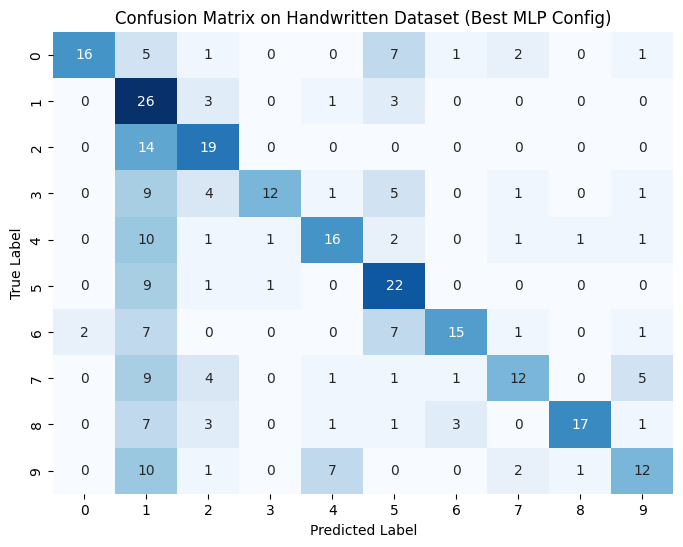

In [66]:
cm = confusion_matrix(all_labels, all_preds)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Handwritten Dataset (Best MLP Config)")

# Save the figure
os.makedirs("results", exist_ok=True)
plt.savefig("results/confusion_matrix.png")
plt.show()